In [96]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
"""
Parse RSS Feed.

"""

import feedparser

# rss keys -> dict_keys(['title', 'title_detail', 'links', 'link', 'id', 'guidislink', 'published', 'published_parsed', 'sa_author_name', 'media_thumbnail', 'href', 'sa_picture', 'sa_symbol', 'sa_company_name', 'sa_stock'])

def rss_parser(url):
    """
    Seeking Alpha RSS news parser.

    Parameters
    ----------
    url: str, rss feed url

    Returns
    -------
    news: dict, news fed by seeking alpha
    """
    # parse news
    try:
        NewsFeed = feedparser.parse(url)
    except Exception as e:
        print("RSS feed not found.")
        print(e)

    # get entries
    entries = NewsFeed.entries
    n_entries = len(entries)
    if n_entries < 1:
        print("Ticker not found or no news available.")
        return None
    print(f"Number of RSS posts: {n_entries}")

    # dict keys
    keys = ["title", "link", "published", "sa_company_name", "sa_author_name"]

    # store data in dict
    news = dict()
    for idx in range(n_entries):
        # get entry
        entry = entries[idx]
        # save relevant data in dict
        entry_dict = {key: entry[key] for key in keys}
        # save news
        news[idx] = entry_dict
    
    return news



In [3]:
tsla = yf.Ticker("TSLA")

In [4]:
price_data = yf.download(
    tickers="TSLA",
    period="1mo",
    interval="1d"
)
price_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-18,669.750000,695.770020,669.349976,688.989990,688.989990,20349400
2021-08-19,678.210022,686.549988,667.590027,673.469971,673.469971,14313500
2021-08-20,682.849976,692.130005,673.700012,680.260010,680.260010,14781800
2021-08-23,685.440002,712.130005,680.750000,706.299988,706.299988,20264900
2021-08-24,710.679993,715.219971,702.640015,708.489990,708.489990,13083100


In [5]:
close_volume = price_data.loc[:, ["Close", "Volume"]]
close_volume = close_volume.reset_index()
close_volume = close_volume.rename(columns={"Date": "date", "Close": "close", "Volume": "volume"})


In [6]:
url = "https://seekingalpha.com/api/sa/combined/TSLA.xml"
news = rss_parser(url)

Number of RSS posts: 30


In [78]:
# merge inferences with news
dates = []
titles = []
links = []
for i in range(len(news)):
    item = news[i]
    dates.append(item["published"][:-15])   # keep date only
    titles.append(item["title"])
    links.append(item["link"])

data = pd.DataFrame([dates, titles, links]).T
data = data.rename(columns={0: "date", 1: "title", 2: "link"})
data["date"] = data["date"].map(lambda x: pd.to_datetime(x))
data["sentiment_int"] = [random.randint(-1, 1) for i in range(data.shape[0])]

In [79]:
sent_dates = []
n_news_list = []
sent_scores = [] 
for date in data.date.sort_values().unique():
    news_subset = data.loc[data.date == date]
    sentiment_score = news_subset.sentiment_int.sum() / news_subset.shape[0]
    n_news = news_subset.shape[0]
    sent_dates.append(date)
    n_news_list.append(n_news)
    sent_scores.append(sentiment_score)

ind_data = pd.DataFrame([sent_dates, sent_scores, n_news_list]).T.rename(columns={0: "date", 1: "day_score", 2: "no_news"})
ind_data.head()

,date,day_score,no_news
0,2021-08-24,-0.5,2
1,2021-08-27,0.0,1
2,2021-08-28,1.0,1
3,2021-08-29,1.0,1
4,2021-08-30,-1.0,1


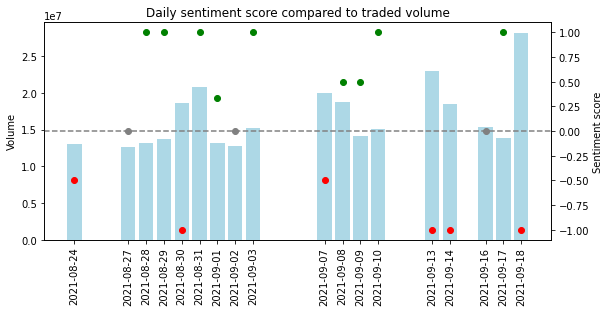

In [104]:
dates_plot = np.array([pd.to_datetime(date, format="%Y-%m-%d") for date in ind_data.date.values])
dates_labels =  [str(date)[:-9] for date in dates_plot]
volume = close_volume.loc[close_volume.date >= min(dates_plot), "volume"]
sentiment_scores = ind_data.day_score.values

fig = plt.figure(figsize=(20,4))

ax1 = plt.subplot(121)
ax2 = ax1.twinx()

# conditional color scatter
pos_idx = sentiment_scores > 0
neg_idx = sentiment_scores < 0
neu_idx = sentiment_scores == 0

b = ax1.bar(dates_plot, volume, color="lightblue")
s = ax2.scatter(dates_plot[pos_idx], sentiment_scores[pos_idx], color="green")
s2 = ax2.scatter(dates_plot[neg_idx], sentiment_scores[neg_idx], color="red")
s3 = ax2.scatter(dates_plot[neu_idx], sentiment_scores[neu_idx], color="gray")

ax1.set_xticks(dates_plot)
ax1.set_xticklabels(dates_labels, rotation=90)
ax1.set_ylabel("Volume")
ax2.set_ylabel("Sentiment score")

ax2.axhline(0, 0, 1, color="gray", linestyle="--")
plt.title("Daily sentiment score compared to traded volume")
